In [3]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
from torchvision.transforms import *


transform=transforms.Compose(
    [
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomAffine((0,180),(0.1,0.2)),
    transforms.ToTensor(),
    ]
)
from torch.utils.data import DataLoader
import numpy as np


In [4]:
data_dir = r"C:\Users\HARRY\Desktop\cassava-leaf-disease-classification"  #data path
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
#load Dataset
image_folder = r'C:\Users\HARRY\Desktop\cassava-leaf-disease-classification\train_images'
class LEAFDataset(Dataset):
    def __init__(self, df, transforms=None):

        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        image_file = os.path.join(image_folder, img_id)
        image=Image.open(image_file)
        
        if self.transforms is not None:
            image = self.transforms(image)
        image = np.array(image).astype(np.float32)
        image /= 255
        

        return torch.tensor(image), torch.tensor(row.label)

In [6]:
import torchvision.models as mds
model = mds.resnext50_32x4d(True)
model.fc = nn.Linear(2048,5)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [7]:
#train model 
import pytorch_warmup as warmup
import sys
true_label=[]
pre_label=[]
learning_rate = 0.001
EPOCH = 40

opti = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9 )
loss_function=nn.CrossEntropyLoss()
choose = 0
def train(*,epoch, model, train_dataset, loss_function, optimizer):
    sum_loss = 0
    for i,data in enumerate(train_dataset):
        #lr_scheduler.step(epoch-1)
        #warmup_scheduler.dampen()
        optimizer.zero_grad()
        features, labels = data
        features=features.cuda()
        labels=labels.cuda()
        out = model(features)
        loss = loss_function(out, labels)
        sum_loss += loss.item()
        sys.stdout.write("\r{0}".format(
                "{}/{}".format(i+1, len(train_dataset))))
        loss.backward()
        optimizer.step()
    return float(sum_loss/len(train_dataset))


def test(*, model, test_dataset, train_dataset):
    def check(dataset):
        right = 0
        total = 0
        with torch.no_grad():
            for data in dataset:
                image, label = data
                true_label.append(label)
                image = image.cuda()
                label = label.cuda()
                out = model(image)
                total = total+out.size(0)
                _, index = torch.max(out.data, dim=1)
                pre_label.append(index)
                right += (index == label).sum().item()
        return float(right / total)
    return check(train_dataset), check(test_dataset)
print("done")

done


In [8]:
full_dataset=LEAFDataset(df_train,transform)
size = int(0.1*len(full_dataset))
split_size = [size for i in range(9)]
split_size.append(len(full_dataset)-sum(split_size))
Datasets = torch.utils.data.random_split(
    full_dataset,split_size,generator=torch.Generator().manual_seed(42))
for idx,d in enumerate(Datasets):
  print("Dataset {} : length : {}".format(idx,len(d)))

Dataset 0 : length : 2139
Dataset 1 : length : 2139
Dataset 2 : length : 2139
Dataset 3 : length : 2139
Dataset 4 : length : 2139
Dataset 5 : length : 2139
Dataset 6 : length : 2139
Dataset 7 : length : 2139
Dataset 8 : length : 2139
Dataset 9 : length : 2146


In [9]:
BATCH_SIZE  = 40
DataLoaders = [DataLoader(d,batch_size=BATCH_SIZE,shuffle=True) for d in Datasets]

In [10]:
def ChooseDataset(index):
  test_dataset = None
  train_datasets = []
  for i in range(len(DataLoaders)):
    if index == i:
      test_dataset = DataLoaders[i]
    else:
      train_datasets.append(DataLoaders[i])
  return train_datasets,test_dataset

In [9]:
#Setting parameters

train_acc_list = []
test_acc_list  =[]
loss_list =[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
for i in range(EPOCH):
    if choose % 10 == 0:
        choose = 0
    train_datasets,test_dataset = ChooseDataset(choose)
    choose+=1
    train_loss = 0.0
    for train_dataset in train_datasets:
      train_loss += train(epoch = i+1,model = model,train_dataset=train_dataset,loss_function=loss_function,optimizer=opti)
    train_acc,test_acc = test(model=model,test_dataset=test_dataset,train_dataset=train_datasets[np.random.randint(0,8)])
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    loss_list.append(float(train_loss/9))
    print("\n E:{}  acc={}(on train_dataset) acc={}(on test_dataset) loss={}".format(i+1,train_acc,test_acc,float(train_loss/9)))

54/54
 E:1  acc=0.7914913510986442(on train_dataset) acc=0.793361383824217(on test_dataset) loss=0.7083870396937854
54/54
 E:2  acc=0.8181393174380551(on train_dataset) acc=0.7961664329125759(on test_dataset) loss=0.5295082758115642
54/54
 E:3  acc=0.8494623655913979(on train_dataset) acc=0.8326320710612436(on test_dataset) loss=0.49453225909682463
54/54
 E:4  acc=0.8433847592332866(on train_dataset) acc=0.8401122019635343(on test_dataset) loss=0.46419525121955707
54/54
 E:5  acc=0.8405797101449275(on train_dataset) acc=0.8429172510518934(on test_dataset) loss=0.4531319852872395
54/54
 E:6  acc=0.8541374474053296(on train_dataset) acc=0.8424497428705002(on test_dataset) loss=0.4303927357182091
54/54
 E:7  acc=0.8396446937821412(on train_dataset) acc=0.8485273492286115(on test_dataset) loss=0.42816343106360105
54/54
 E:8  acc=0.8639551192145862(on train_dataset) acc=0.8499298737727911(on test_dataset) loss=0.415771590154848
54/54
 E:9  acc=0.8644226273959794(on train_dataset) acc=0.8634

In [10]:
#torch.save(model.state_dict(),"resnext_full(SGD).pth")

In [11]:
def test_network(net,testloader):
    net.eval()
    total_images = 0
    total_correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    print('      Accuracy on {0} test images: {1:.2f}%'.format(
                                total_images, model_accuracy))
    net.train()
    return model_accuracy
def predict(net,testloader):
    net.eval()
    total_images = 0
    total_correct = 0
    predict = []
    true    = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            predict += predicted.cpu().numpy().tolist()
            true    += labels.cpu().numpy().tolist()
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    net.train()
    return predict,true

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_model = mds.resnext50_32x4d(True)
test_model.fc = nn.Linear(2048,5)
path  = r"C:\Users\HARRY\Desktop\Resnext50 完整数据集(Adamw)\resnext_full.pth"
test_model.load_state_dict(torch.load(path))
test_model = test_model.to(device)

In [21]:
test_accuracy = []
for dataset in DataLoaders:
    test_accuracy.append(test_network(test_model,dataset))

      Accuracy on 2139 test images: 92.15%
      Accuracy on 2139 test images: 93.36%
      Accuracy on 2139 test images: 92.15%
      Accuracy on 2139 test images: 93.55%
      Accuracy on 2139 test images: 93.31%
      Accuracy on 2139 test images: 93.31%
      Accuracy on 2139 test images: 93.64%
      Accuracy on 2139 test images: 93.50%
      Accuracy on 2139 test images: 93.55%
      Accuracy on 2146 test images: 93.85%


In [18]:
pred,true = predict(test_model,DataLoaders[np.random.randint(0,9)])

In [19]:
from sklearn.metrics import classification_report  
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69       100
           1       0.87      0.75      0.81       219
           2       0.88      0.75      0.81       233
           3       0.94      0.97      0.95      1346
           4       0.67      0.82      0.74       241

    accuracy                           0.89      2139
   macro avg       0.84      0.78      0.80      2139
weighted avg       0.89      0.89      0.89      2139



[[0.75 0.02 0.   0.03 0.2 ]
 [0.   0.88 0.02 0.05 0.05]
 [0.   0.01 0.84 0.08 0.07]
 [0.   0.   0.01 0.97 0.02]
 [0.01 0.04 0.04 0.05 0.86]]


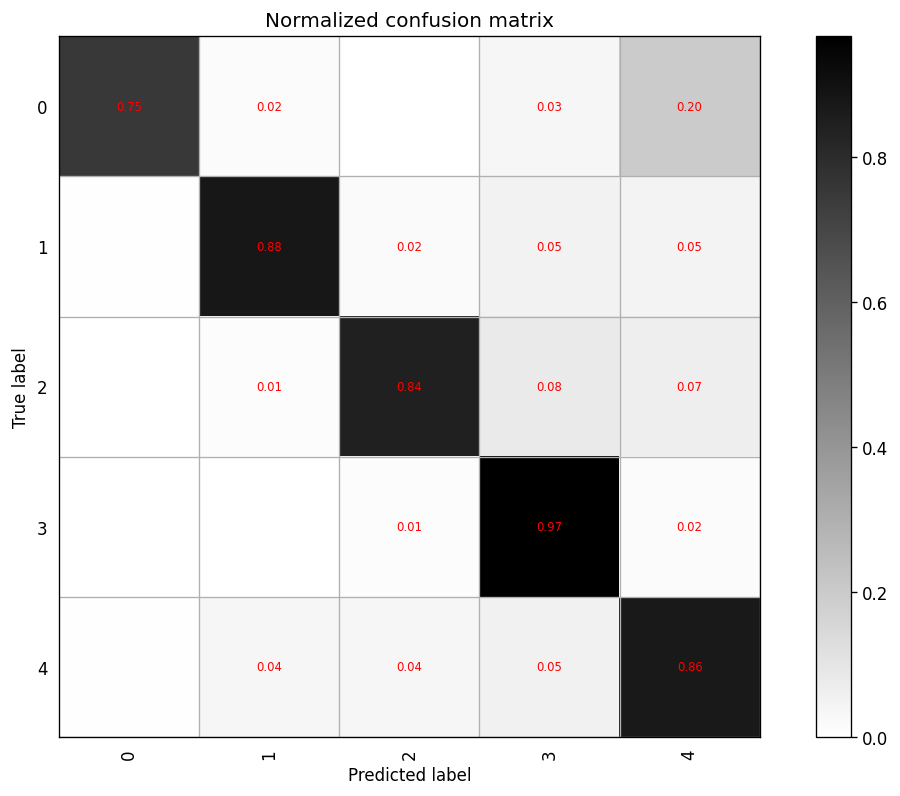

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = [str(i) for i in range(5)]

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if c > 0.01:
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')